# Sea ice deformation from the ice floe tracker measurements
We next turn to sea ice deformation. Deformation estimation requires a consideration of averaging area, and thus the relationship to spatial scaling for deformation differs from that of the FSD and the velocity distributions. In addition to possible effects of floe sizes, we consider the length scale defined by the square root of the area of the triangle used in the strain rate calculation. Prior work has shown that the deformation rate has a fractal-like scale dependence such that the deformation rates are linearly related to the spatial scale in log-log space: $\dot \epsilon \sim L^{-\beta}$. This is a power law form, but does not describe a statistical power law distribution.


To fit the paper better, I need to relate the deformation to the floe-scale ice motion
- smaller floes have higher perturbation velocity --> does that correspond to large deformation?
- how much of the deformation is from the large-scale flow field vs the perturbation velocities?
- if the polygon area is similar to the floe size then we'd see more granular flow effects probably.
   - Does the grain size, perhaps the area/total floe area matter?
- To what extent does the day-to-day variation in the number of polygons matter?
  - Current version has tons of overlapping polygons
  - Better to triangulate instead?


Needs for the updated methods
* Test whether I can use the powerlaw function for this analysis too
* Include floe rotation and area in the analysis



In [1]:
import proplot as pplt
import pandas as pd
import numpy as np
import pyproj
# import powerlaw

In [4]:
# Add this QC to the the merge external step

def net_displacement_meters(floe_df):
    """Calculates net pixel displacement for trajectory"""
    delta_x = floe_df['x_stere'].values[0] - floe_df['x_stere'].values[-1]
    delta_y = floe_df['y_stere'].values[0] - floe_df['y_stere'].values[-1]
    return np.sqrt(delta_x**2 + delta_y**2)

def estimated_max_speed(floe_df):
    """Calculates distance traversed in units of pixels"""
    delta_x = floe_df['x_stere'] - floe_df['x_stere'].shift(-1)
    delta_y = floe_df['y_stere'] - floe_df['y_stere'].shift(-1)
    dt = floe_df['datetime'] - floe_df['datetime'].shift(-1)
    return np.round(np.abs(np.sqrt(delta_x**2 + delta_y**2)/dt.dt.total_seconds()).max(), 3)

In [474]:
# projIn = 'epsg:4326' # WGS 84 Ellipsoid
# projOut = 'epsg:3413' # NSIDC North Polar Stereographic
# transformer_ps = pyproj.Transformer.from_crs(projIn, projOut, always_xy=True)
def mean_accel(xcomp, ucomp, area, sign):
    """xcomp and ucomp input should be an N x 3 array. Different gradients will need
    different combinations of x, y, u, and v. In particular:
        dudx = accel(Y, U, A, 1)
        dudy = accel(X, U, A, -1)
        dvdx = accel(Y, V, A, 1)
        dvdy = accel(X, V, A, -1)
    xcomp should be in polar stereographic components.    
    """
    nr, nc = xcomp.shape
    total = np.zeros(nr)
    for idx in range(nc):
        idx1 = (idx + 1) % nc
        total += (ucomp[:, idx1] + ucomp[:, idx])*(xcomp[:, idx1] - xcomp[:, idx])
    return 1/(2*area) * total * sign

def normal_log_likelihood(eps, L, beta):
    n = len(eps)
    data = np.log(eps*L**beta)
    # trim outliers
    # iqr = np.quantile(data, q=0.75) - np.quantile(data, q=0.25)
    # med = np.median(data)
    # keep = (data <= med + 1.5*iqr) & (data >= med - 1.5*iqr)
    mu = np.mean(data)
    sigma = np.std(data)
    normalizer = -n/2*np.log(2*np.pi*sigma**2)
    return normalizer - np.sum(data - mu)**2/(2*sigma**2)   

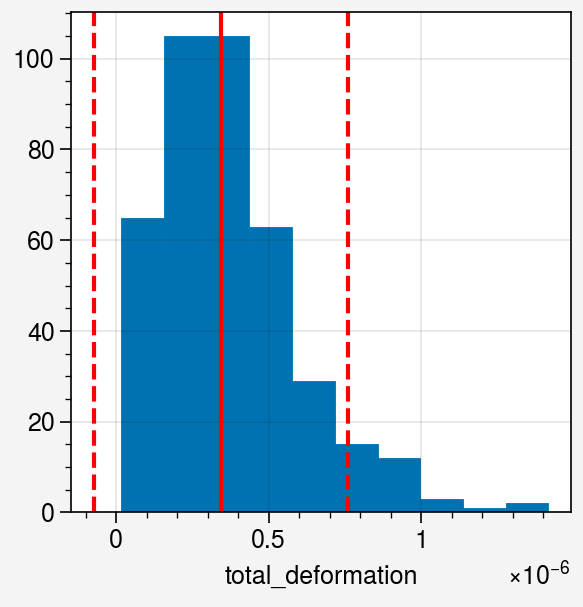

In [470]:
fig, ax = pplt.subplots()
ax.hist(d)
iqr = np.quantile(d, q=0.75) - np.quantile(d, q=0.25)
ax.axvline(np.median(d), color='r')
ax.axvline(np.median(d) - 1.5*iqr, color='r', ls='--')
ax.axvline(np.median(d) + 1.5*iqr, color='r', ls='--')

## Load and clean trajectories

In [6]:
ift_data = pd.read_csv('../data/floe_tracker/ift_floe_trajectories.csv')
ift_data['datetime'] = pd.to_datetime(ift_data['datetime'])
init_n = len(ift_data)

In [7]:
# Require a minimum of at least 1 pixel total displacement
ift_data = ift_data.groupby('floe_id').filter(lambda x: net_displacement_meters(x) > 500)

# Max speed has to be less than 1 m/s and greater than 0.05 m/s
ift_data = ift_data.groupby('floe_id').filter(lambda x: (estimated_max_speed(x) < 1) & \
            (estimated_max_speed(x) > 0.05))

In [8]:
ift_data.columns

Index(['Unnamed: 0', 'datetime', 'floe_id', 'longitude', 'latitude', 'x_stere',
       'y_stere', 'area', 'perimeter', 'axis_major_length',
       'axis_minor_length', 'solidity', 'circularity', 'nsidc_sic',
       'lr_probability', 'zeta', 'zeta_est', 'u', 'v', 'bearing', 'speed',
       'area_km2', 'perimeter_km', 'axis_major_length_km',
       'axis_minor_length_km', 'edge_dist_km', 'coast_dist_km', 'u_nsidc',
       'v_nsidc', 'u5D_nsidc', 'v5D_nsidc', 'u15D_nsidc', 'v15D_nsidc',
       'u31D_nsidc', 'v31D_nsidc'],
      dtype='object')

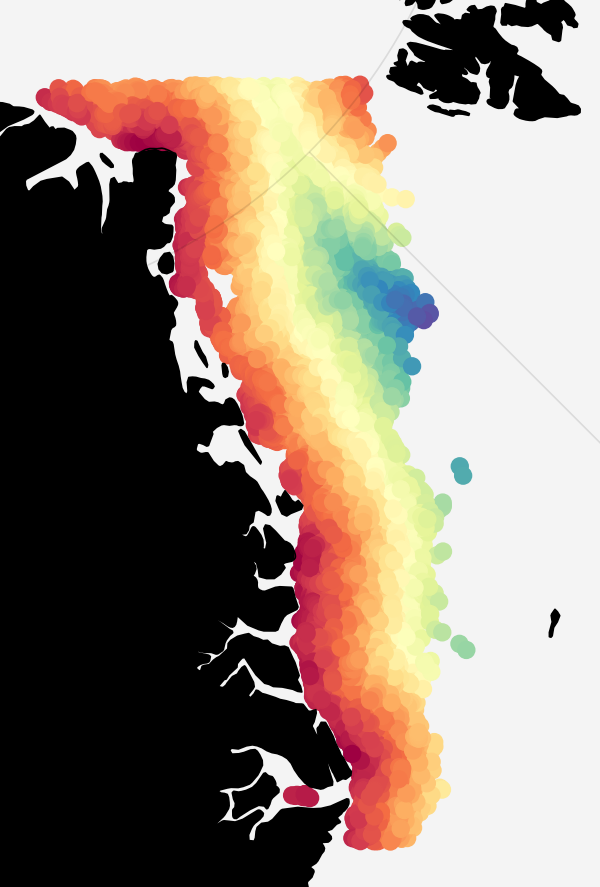

In [9]:
import cartopy.crs as ccrs
import warnings
warnings.simplefilter('ignore')

pplt.rc.reso = 'med'
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)

fig, ax = pplt.subplots(width=3, proj='npstere', proj_kw={'lon_0': -45})
ax.format(land=True, coast=True, landzorder=0, landcolor='k', facecolor='w')

ax.set_extent([0.2e6, 1.3e6, -2.15e6, -0.5e6], crs=crs)  
long_tracks = ift_data.groupby('floe_id').filter(lambda x: len(x) > 40)

ax.scatter(ift_data.loc[:, 'x_stere'].values,
           ift_data.loc[:, 'y_stere'].values, 
           c = ift_data.loc[:, 'coast_dist_km'].values, 
           transform=crs, cmap='spectral')

In [51]:
# Loading data
logbins = np.logspace(np.log(10), np.log(300), base=np.e, num=10)
data = []
years = []
all_data = []
for year in range(2003, 2021):
    results = pd.read_csv('../data/deformation/polygons_' + str(year) + '.csv')
    results = results.dropna(subset=['u1', 'u2', 'u3'])
    results.rename({'Unnamed: 0': 'datetime', 'Unnamed: 1': 'triangle_number'}, axis=1, inplace=True)
    results['datetime'] = pd.to_datetime(results['datetime'].values)
    
    results['L'] = np.sqrt(results['polygon_area'])
    results['log_bin'] = np.digitize(results['L'], logbins)
    all_data.append(results)
    years.append(year)
    data.append(results.groupby('log_bin').count()['datetime'].values)
df_info = pd.DataFrame(data, index=years)

all_results = pd.concat(all_data, axis=0)
all_results.reset_index(drop=True, inplace=True)

In [199]:
results['log_bin'].loc[results['L'] > 300]

34623      10
34625      10
34626      10
34628      10
34629      10
           ..
1540647    10
1542416    10
1542417    10
1542418    10
1544724    10
Name: log_bin, Length: 10757, dtype: int64

In [11]:
all_results.dropna(subset=['u1', 'u2', 'u3']).shape, all_results.shape

((546638, 33), (546638, 33))

In [12]:
n_per_image = all_results.groupby('datetime').apply(lambda x: len(x))
n_per_image.loc[n_per_image > 20000]

datetime
2003-05-12 12:00:00    26350
2003-05-13 12:00:00    34972
2003-05-14 12:00:00    46950
2003-05-15 12:00:00    23083
2003-05-23 12:00:00    23522
2003-05-24 12:00:00    33646
2003-05-25 12:00:00    20598
2003-06-02 12:00:00    23236
2003-06-03 12:00:00    23408
2003-06-15 12:00:00    35040
2003-06-16 12:00:00    48918
2003-06-17 12:00:00    29522
dtype: int64

<a list of 1 Line2D objects>

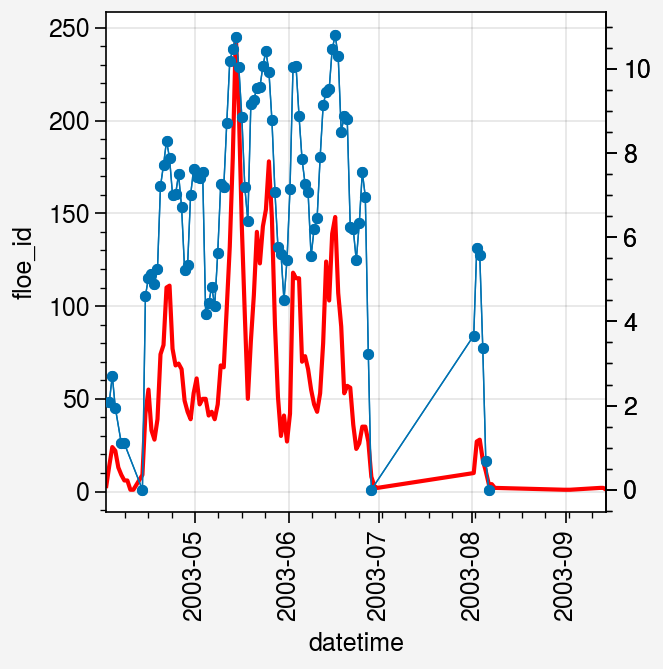

In [14]:
fig, ax = pplt.subplots()
ax.plot(ift_data.loc[(ift_data.floe_id != 'unmatched') & (ift_data.datetime.dt.year == 2003)].groupby('datetime').count()['floe_id'], c='r')
ax2 = ax.twinx()
ax2.plot(np.log(n_per_image.loc[slice('2003-03-01', '2003-09-01')]), lw=0.5, m='.')

In [64]:
%%time
all_results['sampled'] = False
# all_results['sampled2'] = False
for date, date_group in all_results.loc[~all_results.sampled].groupby('datetime'):
    for bin_number, bin_group in date_group.groupby('log_bin'):
        used = []
        # set a different random state for each date and bin number, so it's reproducible but not 
        # sorting things the same way each day
        random_state = pd.to_datetime(date).year*1000 + pd.to_datetime(date).dayofyear + bin_number
        
        for row, data in bin_group.sample(frac=1, random_state=random_state).iterrows():
            if (data.floe1 in used) | (data.floe2 in used) | (data.floe3 in used):
                pass
            else:
                used.append(data.floe1)
                used.append(data.floe2)
                used.append(data.floe3)
                all_results.loc[row, 'sampled'] = True


CPU times: user 1min 49s, sys: 1.14 s, total: 1min 51s
Wall time: 1min 51s


Sampling unique triangles in this manner 

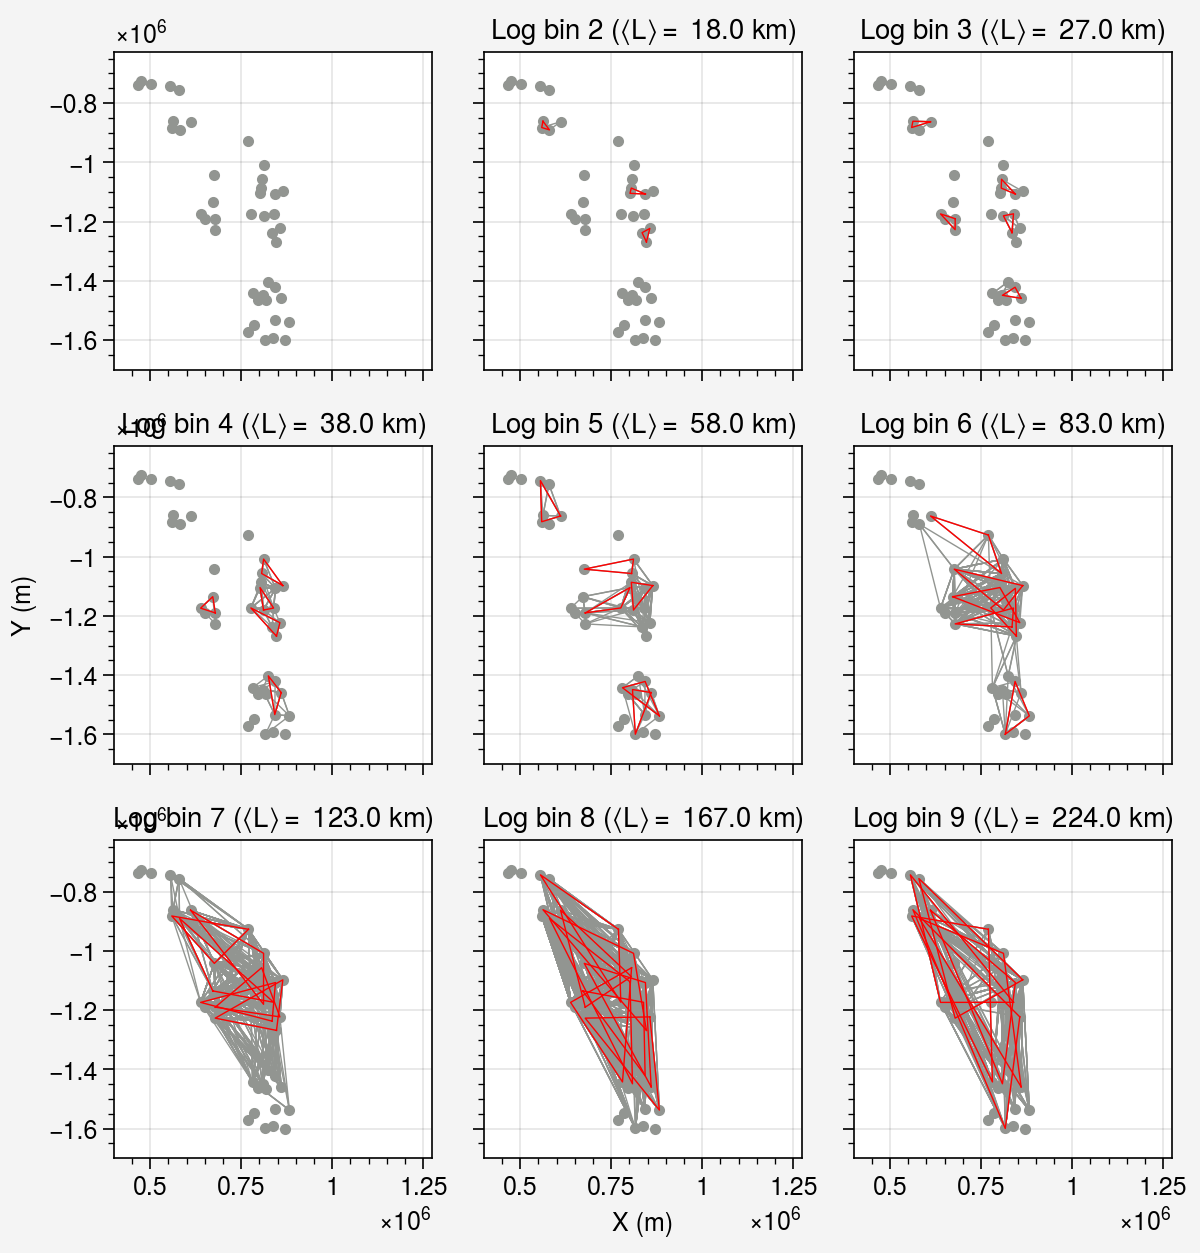

In [272]:
# fig, axs = pplt.subplots(ncols=3, width=8, height=3, proj='npstere', proj_kw={'central_longitude': -45, 'true_scale_latitude': 70})
# crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
fig, axs = pplt.subplots(ncols=3, nrows=3, width=6)
test = all_results.loc[all_results.datetime == '2003-06-01 12:00:00']
# axs.format(land=False, coast=False, landzorder=0, landcolor='k', facecolor='w')

for ax, log_bin in zip(axs, np.arange(1, 10)):  
    # ax.set_extent([0.2e6, 1.3e6, -2e6, -0.5e6], crs=crs)  
    color = 'r'
    all_points = ift_data.loc[ift_data.datetime == '2003-06-01 12:00:00']
    dx = max((all_points.x_stere.max() - all_points.x_stere.min()), (all_points.y_stere.max() - all_points.y_stere.min()))
    ax.plot(all_points.loc[:, 'x_stere'].values, all_points.loc[:, 'y_stere'].values, marker='.', color='gray', lw=0)
    for row, data in test.loc[test.log_bin == log_bin,:].iterrows():
        ax.plot([data.x1, data.x2, data.x3, data.x1],
                [data.y1, data.y2, data.y3, data.y1], lw=0.5, c='gray', marker='')
    for row, data in test.loc[test.sampled & (test.log_bin == log_bin),:].iterrows():
        mean_size = test.loc[test.sampled & (test.log_bin == log_bin), 'L'].mean()
        ax.plot([data.x1, data.x2, data.x3, data.x1],
                [data.y1, data.y2, data.y3, data.y1], lw=0.5, c=color, marker='')
        ax.format(xreverse=False, xlabel='X (m)', ylabel='Y (m)', ylim=(-1.7e6, -1.5e6+dx), xlim=(0.4e6, 0.4e6 + dx),
                 title='Log bin ' + str(log_bin) + ' ($\\langle L \\rangle = $ ' + str(np.round(mean_size, 0)) + ' km)')

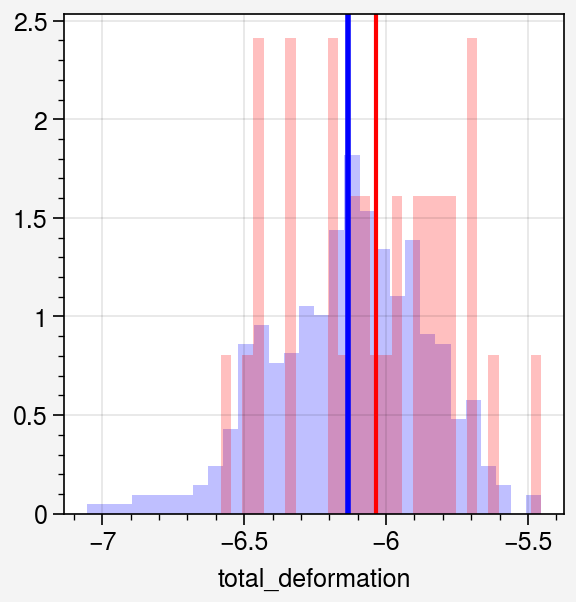

In [307]:
fig, ax = pplt.subplots()
test=all_results.loc[(all_results.datetime.dt.year==2010) & (all_results.datetime.dt.month==6)]
log_bin = 5
ax.hist(np.log10(test.loc[test.log_bin == log_bin, 'total_deformation']), bins=30, density=True, alpha=0.25, color='b')

ax.hist(np.log10(test.loc[test.sampled & (test.log_bin == log_bin), 'total_deformation']), bins=30, density=True, alpha=0.25, color='r')
ax.axvline(np.log10(test.loc[test.log_bin == log_bin, 'total_deformation']).mean(), color='b', lw=2)
ax.axvline(np.log10(test.loc[test.sampled & (test.log_bin == log_bin), 'total_deformation']).mean(), color='r')

In [66]:
# get xcoords
projIn = 'epsg:4326' # WGS 84 Ellipsoid
projOut = 'epsg:3413' # NSIDC North Polar Stereographic
transformer_ps = pyproj.Transformer.from_crs(projIn, projOut, always_xy=True)

for idx in range(1, 4):
    x, y = transformer_ps.transform(all_results['lon' + str(idx)], all_results['lat' + str(idx)])
    all_results['x' + str(idx)] = x
    all_results['y' + str(idx)] = y

xcoords = np.array([all_results['x1'], all_results['x2'], all_results['x3']]).T
ycoords = np.array([all_results['y1'], all_results['y2'], all_results['y3']]).T
ucoords = np.array([all_results['u1'], all_results['u2'], all_results['u3']]).T
vcoords = np.array([all_results['v1'], all_results['v2'], all_results['v3']]).T

# TBD: Change area calculation to stereographic

area = all_results['polygon_area'].values*1e6 # convert back to meters. This area was calculated with LAEA

dudx = mean_accel(ycoords, ucoords, area, 1)
dudy = mean_accel(xcoords, ucoords, area, -1)
dvdx = mean_accel(ycoords, vcoords, area, 1)
dvdy = mean_accel(xcoords, vcoords, area, -1)

all_results['divergence'] = dudx + dvdy #div
all_results['vorticity'] = dvdx - dudy #vor
all_results['pure_shear'] = dudy + dvdx #pure
all_results['normal_shear'] = dudx - dvdy #normal
all_results['total_deformation'] = 0.5*np.sqrt((dudx - dvdy)**2 + (dudy + dvdx)**2) #epsilon_ii = total deformation

all_results['month'] = all_results['datetime'].dt.month
all_results['year'] = all_results['datetime'].dt.year


In [26]:
all_results['area_fraction'] = (all_results['area_km21'] + all_results['area_km22'] + all_results['area_km23']) / all_results['polygon_area']

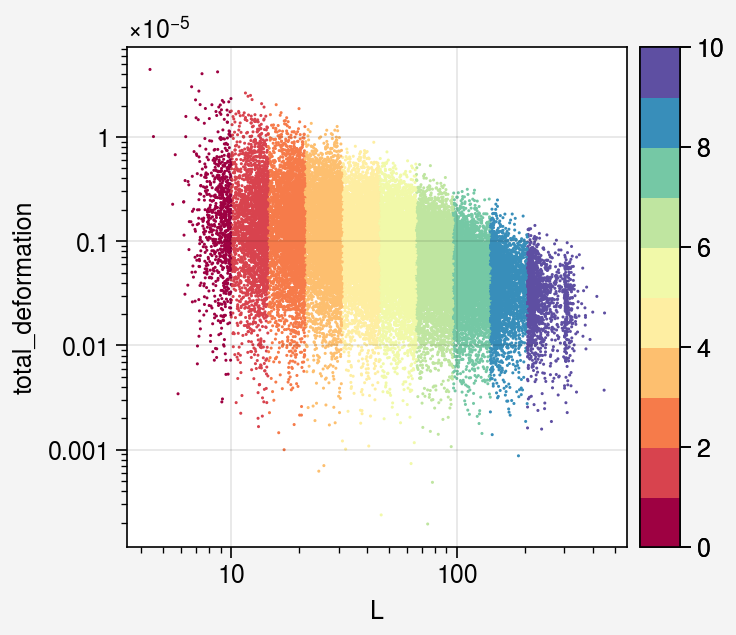

In [201]:
fig, ax = pplt.subplots()
test = all_results.loc[all_results.sampled, :]
c = ax.scatter(test.loc[:, 'L'], test.loc[:, 'total_deformation'],
           c = test.loc[:, 'log_bin'],
           marker='.', color='k', ms=1, cmap='spectral', N=10)
ax.colorbar(c)

ax.format(yscale='log', xscale='log')

Analysis procedure. For each image date, I randomly shuffled the dataset, then iteratively select polygons such that each identified ice floe is only used in one polygon per bin. The minimum and maximum bins are excluded from the analysis since they have relatively few observations and cannot be guaranteed to sample the full bin range.
- min number of obs per bin?
- resampling with different initial sets?
- is the result dependent on the minimum angle? (re-run with it set to 30 degrees)
  
We want to understand the following questions
- Do we observe a similar length scale depends with these MIZ observations as we do with previous studies?
- Does the length scale relationship vary through the summer?
- Within a given range, is (a) the lognormal MLE a consistent method to estimate the scale parameter, and (b) does the lognormal distribution describe the variability within length scale bins?
- Does the 

Emphasize that we are not testing whether deformation distributions follow a power law, we are looking at whether the deformation has a power law dependence on the length scale. We are not expecting the counts to follow any particular distribution, this is not a probability distribution function.

Goodness of fit: qq plots by bin size for each month
- question of what is happening in the tails



In [31]:
import powerlaw

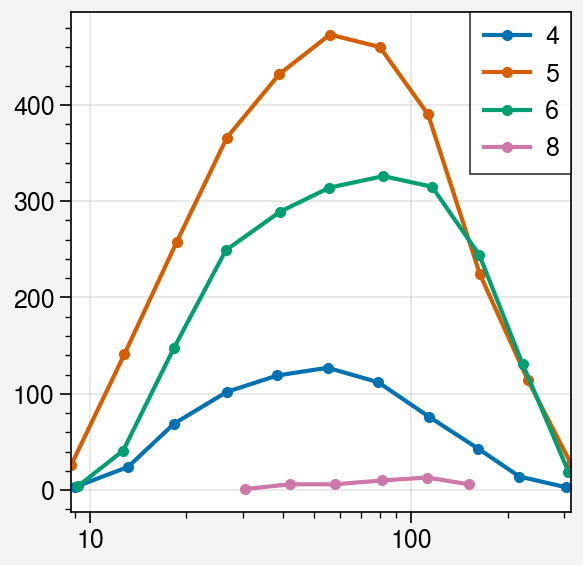

In [50]:
fig, ax = pplt.subplots()
for month, data in test.groupby(test.datetime.dt.month):
    counts = data.groupby('log_bin').count()['floe1']
    lengths = data[['L', 'log_bin']].groupby('log_bin').mean()['L']
    ax.plot(lengths.values, counts.values, marker='.', label=month)
    ax.format(xscale='log')
ax.legend(ncols=1)

$$\sigma_A^2 = \frac{\sigma_X^2}{4}(a^2 + b^2 + c^2)$$
For a right triangle with area 10 km and minimum interior angle 20 degrees, we can calculate that

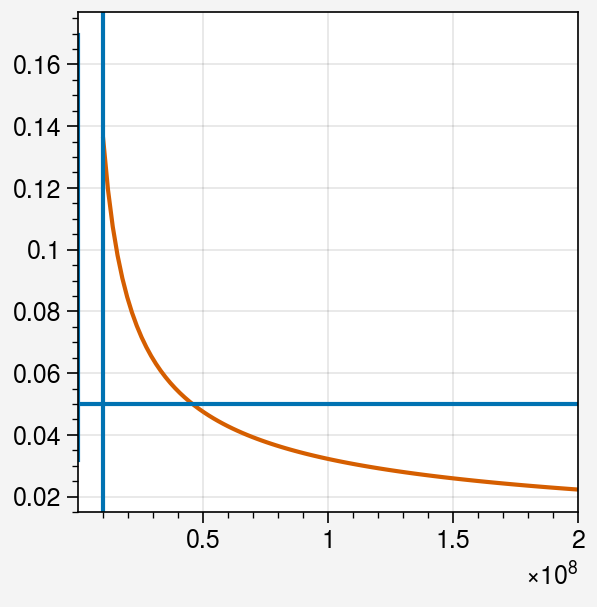

In [64]:
tri_a = np.linspace(10, 200, 100)*1e6
a = np.sqrt(2*tri_a/np.tan(np.deg2rad(10)))
b = a*np.tan(np.deg2rad(20))
c = np.sqrt(h**2 + b**2)
rel_a = np.sqrt(256**2/4*(a**2 + b**2 + c**2))/tri_a
fig, ax = pplt.subplots()
a = np.sqrt(2*tri_a/np.tan(np.deg2rad(10)))
b = a*np.tan(np.deg2rad(10))
c = np.sqrt(h**2 + b**2)
rel_a = np.sqrt(256**2/4*(a**2 + b**2 + c**2))/tri_a
ax.plot(rel_a)
a = np.sqrt(2*tri_a/np.tan(np.deg2rad(30)))
b = a*np.tan(np.deg2rad(30))
c = np.sqrt(h**2 + b**2)
rel_a = np.sqrt(256**2/4*(a**2 + b**2 + c**2))/tri_a
ax.plot(tri_a, rel_a)
ax.axvline(10e6)
ax.axhline(0.05)

We are considering only triangles where the area uncertainty is low

$$\frac{\delta_\epsilon}{\epsilon} = 2\left(4 \frac{\delta_x^2}{A} + 2 \frac{\delta_x^2}{U^2T^2} + \delta_T^2/T^2 + \frac{\delta_A^2}{A^2}\right)^{1/2}$$

In [37]:
def area_uncertainty(data, dx=256):
    a2 = (data.x1 - data.x2)**2 + (data.y1 - data.y2)**2
    b2 = (data.x1 - data.x3)**2 + (data.y1 - data.y3)**2
    c2 = (data.x3 - data.x2)**2 + (data.y3 - data.y2)**2    
    return np.sqrt(dx**2/4*(a2 + b2 + c2))


0    0.005272
1    0.045428
2    0.007233
3    0.007857
4    0.006426
5    0.007084
6    0.006463
7    0.007249
8    0.005164
9    0.006192
dtype: float64

In [38]:
# Add uncertainty calculation here
del_x = 256
T = 24*60*60
del_T = 1*60*60
A = all_results['area']*1e6
del_A = area_uncertainty(all_results)/A
U = ((all_results['u1']**2 + all_results['v1']**2)**0.5 + \
    (all_results['u2']**2 + all_results['v2']**2)**0.5 + \
    (all_results['u3']**2 + all_results['v3']**2)**0.5)/3
rel_error = 2*np.sqrt(4*del_x**2/A + \
                      2*del_x**2/(df_test['U']**2*T**2) + \
                      del_T**2/T**2 + \
                      del_A**2/A**2)

In [61]:
del all_results

In [376]:
%%time
# Make monthly sample set
rs = 32413
n = 500
samples = {4: [], 5: [], 6: []}
for (month, log_bin), group in all_results.loc[all_results.sampled,:].groupby(['month', 'log_bin']):         
    if len(group) >= n:
        if month in samples:
            w = 1 / group.groupby('datetime').transform(lambda x: len(x))['triangle_number']
            samples[month].append(group.sample(n, replace=False, weights=w, random_state=rs + month + log_bin))
            # weight this by the number of observations per day within each bin
    else:
        print(month, log_bin, len(group))

4 0 286
4 9 441
4 10 93
5 0 319
5 9 386
5 10 79
6 0 222
6 9 467
6 10 85
7 0 8
7 1 48
7 2 96
7 3 164
7 4 233
7 5 264
7 6 242
7 7 176
7 8 99
7 9 43
7 10 9
8 0 7
8 1 12
8 2 22
8 3 36
8 4 46
8 5 47
8 6 49
8 7 50
8 8 26
8 9 3
9 1 2
9 2 5
9 3 8
9 4 11
9 5 9
9 6 8
9 7 4
9 8 1
CPU times: user 3.01 s, sys: 20.9 ms, total: 3.03 s
Wall time: 3.02 s


# Sensitivity of the likelihood results to the sample size
Some questions here: we're using MLE to find the slope. The new sampling method does show some differences, particularly for April. I need to figure out how things vary by length scale, and whether I'm getting the best fit with the lognormal functions. 



MultiIndex([('datetime',  0),
            ('datetime',  1),
            ('datetime',  2),
            ('datetime',  3),
            ('datetime',  4),
            ('datetime',  5),
            ('datetime',  6),
            ('datetime',  7),
            ('datetime',  8),
            ('datetime',  9),
            ('datetime', 10)],
           names=[None, 'log_bin'])

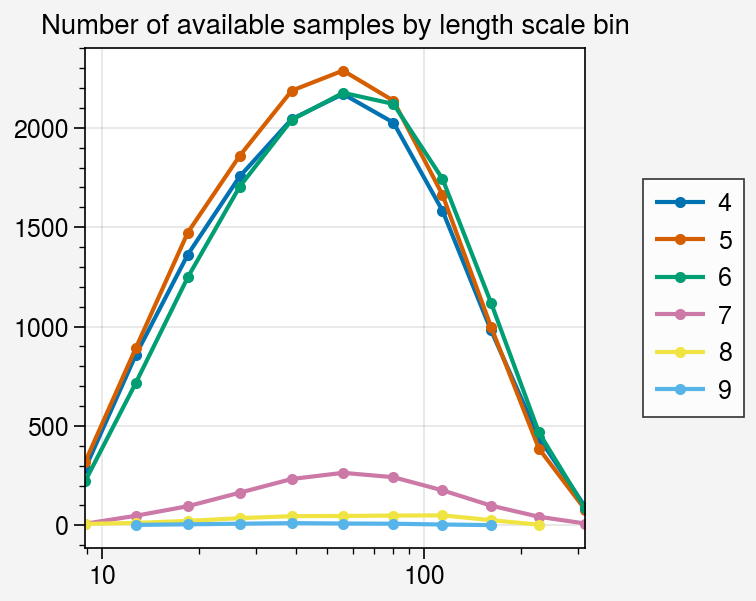

In [406]:
fig, ax = pplt.subplots()
df = all_results.loc[all_results.sampled,:].groupby(['month', 'log_bin']).count()[['datetime']].pivot_table(index='month', columns='log_bin', values='datetime').T
lbins = all_results.loc[all_results.sampled,['log_bin', 'L']].groupby('log_bin').mean()
for row, data in df.T.iterrows():
    ax.plot(lbins, data.values, label=row, marker='.')
ax.format(xscale='log', title='Number of available samples by length scale bin')
ax.legend(ncols=1, loc='r')

In [ ]:
%%time
# Build bootstrap analysis of slopes
bs_table = []
for month in samples:
    strat_samp = pd.concat(samples[month], axis=0)
    bs_results = []
    for repeat in range(100):
        resamp = strat_samp.sample(len(strat_samp), replace=True, random_state=rs + repeat)
        likelihood_results = pd.Series(np.nan, index=np.linspace(0.01, 1, 200))
        for beta in likelihood_results.index:
            likelihood_results.loc[beta] = normal_log_likelihood(resamp['total_deformation']*(60*60*24),
                                                                 resamp['L'], beta)
        bs_results.append(likelihood_results.idxmax())
    del likelihood_results
    q1, q2 = np.quantile(np.array(bs_results), [0.025, 0.975])
    bs_table.append([month, q1, q2])
    
bs_table = pd.DataFrame(bs_table, columns=['month', 'min_beta', 'max_beta']).set_index('month')
bs_table['beta'] = np.nan

In [475]:
for month in samples:
    strat_samp = pd.concat(samples[month], axis=0)
    strat_samp = strat_samp.loc[strat_samp['log_bin'] > 1]
    likelihood_results = pd.Series(np.nan, index=np.linspace(0.01, 1, 200))
    for beta in likelihood_results.index:
        likelihood_results.loc[beta] = normal_log_likelihood(strat_samp['total_deformation']*(60*60*24),
                                                             strat_samp['L'], beta)
    beta = likelihood_results.idxmax()
    bs_table.loc[month, 'beta'] = beta
    

In [476]:
bs_table

,min_beta,max_beta,beta,reg_est
month,,,,
4,0.412965,0.477638,0.467688,-0.598726
5,0.547286,0.602010,0.621910,-0.691595
6,0.547286,0.609597,0.666683,-0.681666


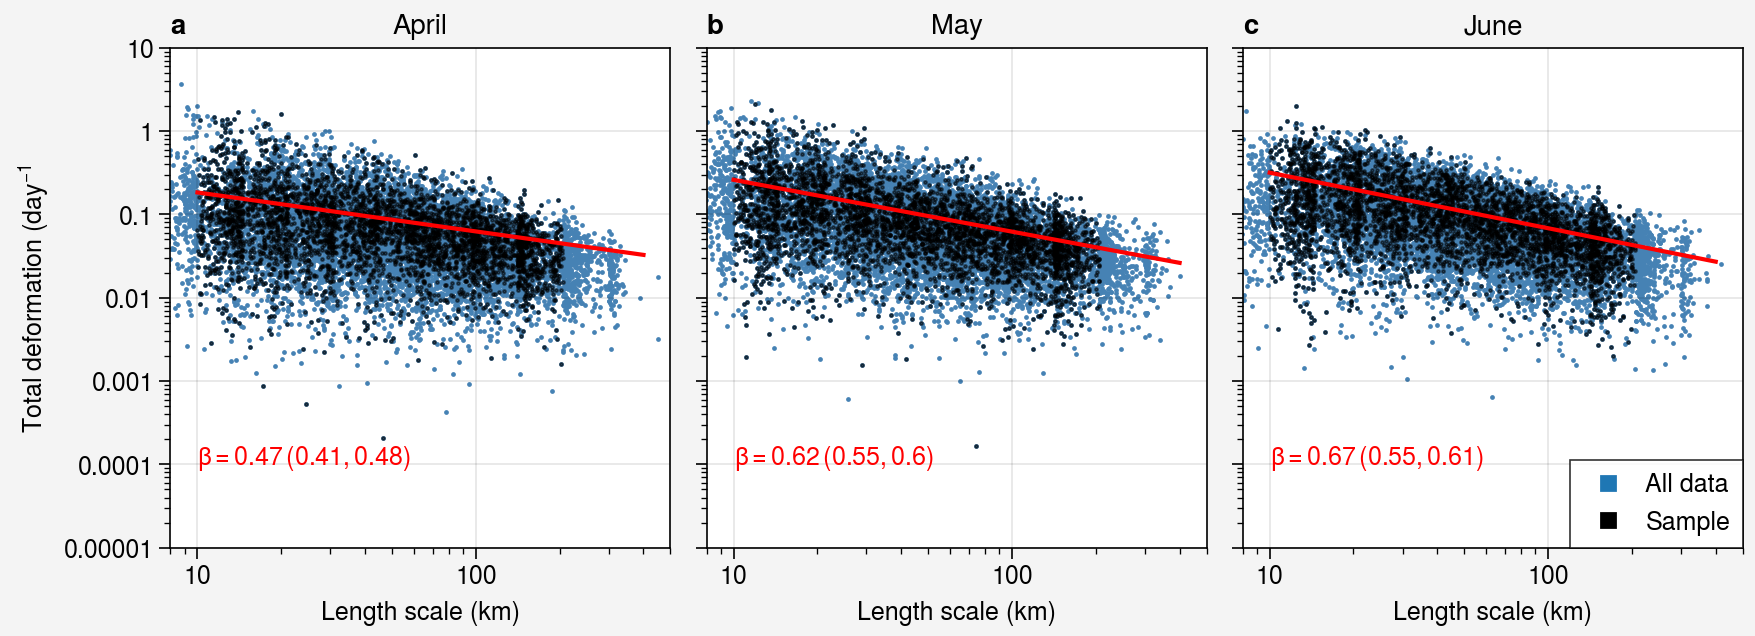

In [477]:
fig, axs = pplt.subplots(ncols=3, nrows=1, spanx=False)
for ax, month, monthname in zip(axs, [4, 5, 6],
                                ['April', 'May', 'June', 'July']):
    beta = bs_table.loc[month, 'beta']
    min_beta = bs_table.loc[month, 'min_beta']
    max_beta = bs_table.loc[month, 'max_beta']    
    all_month = all_results.loc[(all_results.month==month) & (all_results.sampled)]
    strat_samp = pd.concat(samples[month], axis=0)
    ax.scatter(all_month['L'].values, all_month['total_deformation'].values*(60*60*24), marker='.', alpha=1, ms=5, color='steelblue')
    ax.scatter(strat_samp['L'].values, strat_samp['total_deformation'].values*(60*60*24), 
              marker='.', alpha=0.5, ms=5, color='k')
        
    for val, ls in zip([beta], ['-']):
        scaled_eps = strat_samp['total_deformation']*(60*60*24)*strat_samp['L']**val
        mu = np.mean(np.log(scaled_eps))
        sigma = np.std(np.log(scaled_eps))
        mean = np.exp(mu + sigma**2/2)
    
        ax.plot([10, 400], [mean*10**(val * -1),
                            mean*400**(val * -1)], color='r', ls=ls)
    
    ax.format(xscale='log', yscale='log', xlim=(8, 500), title=monthname, ylim=(1e-5, 10))
    ax.text(10, 1e-4, '$\\beta={b} \, ({minb}, {maxb})$'.format(b=np.round(beta, 2),
                                                              minb=np.round(min_beta, 2),
                                                              maxb=np.round(max_beta, 2)), color='r')

    h = [ax.plot([],[], m='s', lw=0, ms=5, color='tab:blue'),
         ax.plot([],[], m='s', lw=0, ms=5, color='k')]
ax.legend(h, ['All data', 'Sample'], ncols=1, loc='lr')
axs.format(ylabel='Total deformation (day$^{-1}$', xlabel='Length scale (km)', abc=True)
# fig.save('../figures/fig06_deformation_length_scale.jpg', dpi=300)

# Standard approach
The typical approach, used by e.g. Hutchings et al. 2024, involves calculating a mean deformation within length scale bins. 

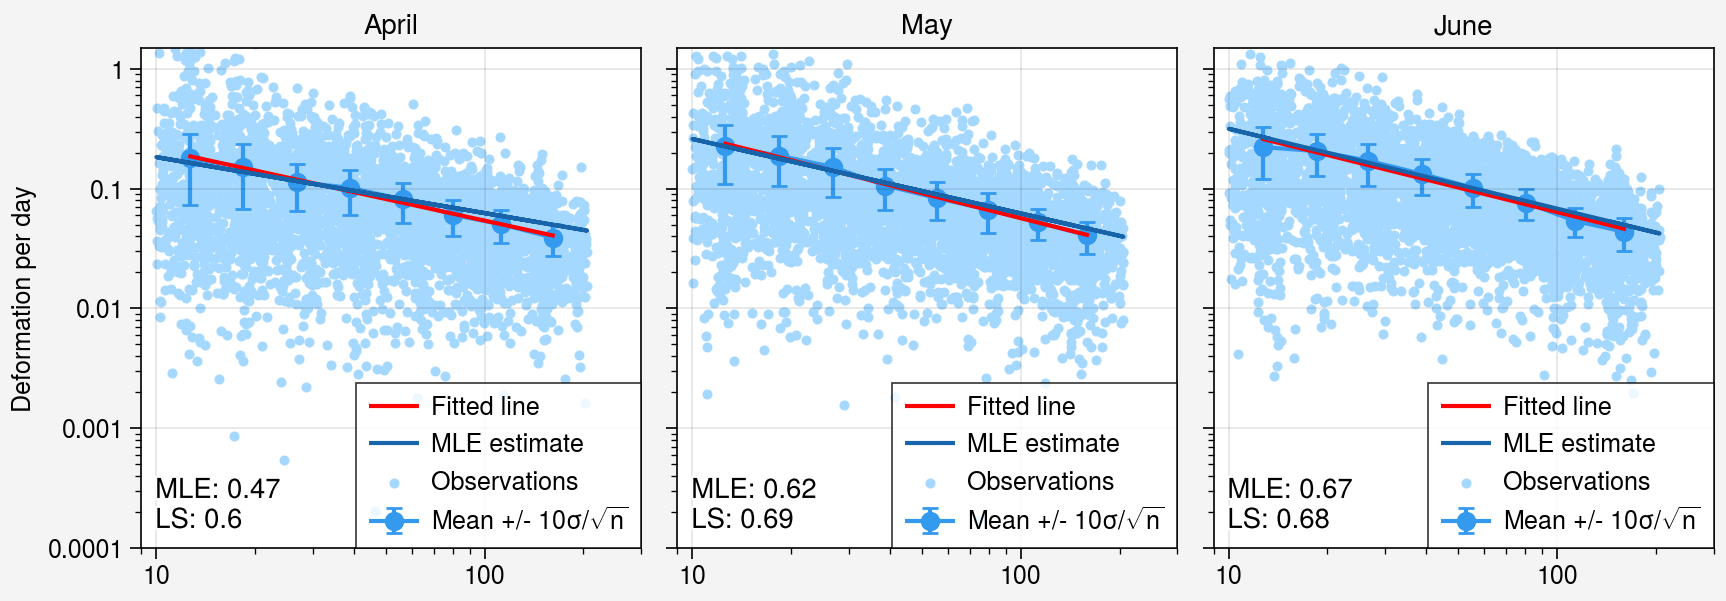

In [478]:
from scipy.stats import linregress
bs_table['reg_est'] = np.nan
fig, axs = pplt.subplots(ncols=3)
for ax, month, monthname in zip(axs, range(4, 7), ['April', 'May', 'June']):
    strat_samp = pd.concat(samples[month], axis=0)
    data = strat_samp.loc[(strat_samp.datetime.dt.month == month) & (strat_samp.sampled)]
    data = data.loc[(data.log_bin > 0) & (data.log_bin < 10)]
    ax.scatter(data['L'].values, data['total_deformation'].values*24*60*60, m='.', color='blue2', zorder=0, label='Observations')
    data_mean = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
    data_std = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').std()
    n = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').count()
    if len(data_mean) > 7:
        beta, a, r, p, err = linregress(np.log(data_mean['L']), np.log(data_mean['total_deformation']*24*60*60))
        
        ax.errorbar(data_mean['L'].values, data_mean['total_deformation'].values*24*60*60, marker='o',
                yerr=10*data_std['total_deformation'].values*24*60*60/np.sqrt(n['total_deformation'].values),
                    label='Mean +/- 10$\sigma/\sqrt{n}$', zorder=1, color='blue5')
        ax.plot(data_mean['L'].values, np.exp(a + np.log(data_mean['L'].values)*beta), label='Fitted line', color='r')
    ax.format(yscale='log', xscale='log', ylim=(1e-4, 1.5), ylabel='Deformation per day', xlim=(9, 300), title=monthname)
    bs_table.loc[month, 'reg_est'] = beta
    
    beta_mle = bs_table.loc[month, 'beta']
    scaled_eps = data['total_deformation']*(60*60*24)*data['L']**beta_mle
    mu = np.mean(np.log(scaled_eps))
    sigma = np.std(np.log(scaled_eps))
    mean = np.exp(mu + sigma**2/2)
    ax.plot(data['L'].values, mean*data['L']**(-1*beta_mle), label='MLE estimate', color='blue9')
    ax.format(lltitle='MLE: ' + str(np.round(beta_mle, 2)) + '\n' + 'LS: ' + str(np.round(-1*beta, 2)), xreverse=False)
    ax.legend(ncols=1,loc='lr')

The line for the MLE method is given by the function
$$ y = mL^{-\beta} $$
where $m = \exp(\mu + \sigma^2/2)$ is the mean of the fitted lognormal distribution with parameters $\mu$, $\sigma$.

TBD:
- Sensitivity of the MLE estimate to outliers
- Sensitivity to sample size
- Uncertainty in the LS mean (add to plot)

In [442]:
import statsmodels.api as sm
np.exp(np.mean(data['total_deformation']*data['L']**beta_mle))

1.000005986501369

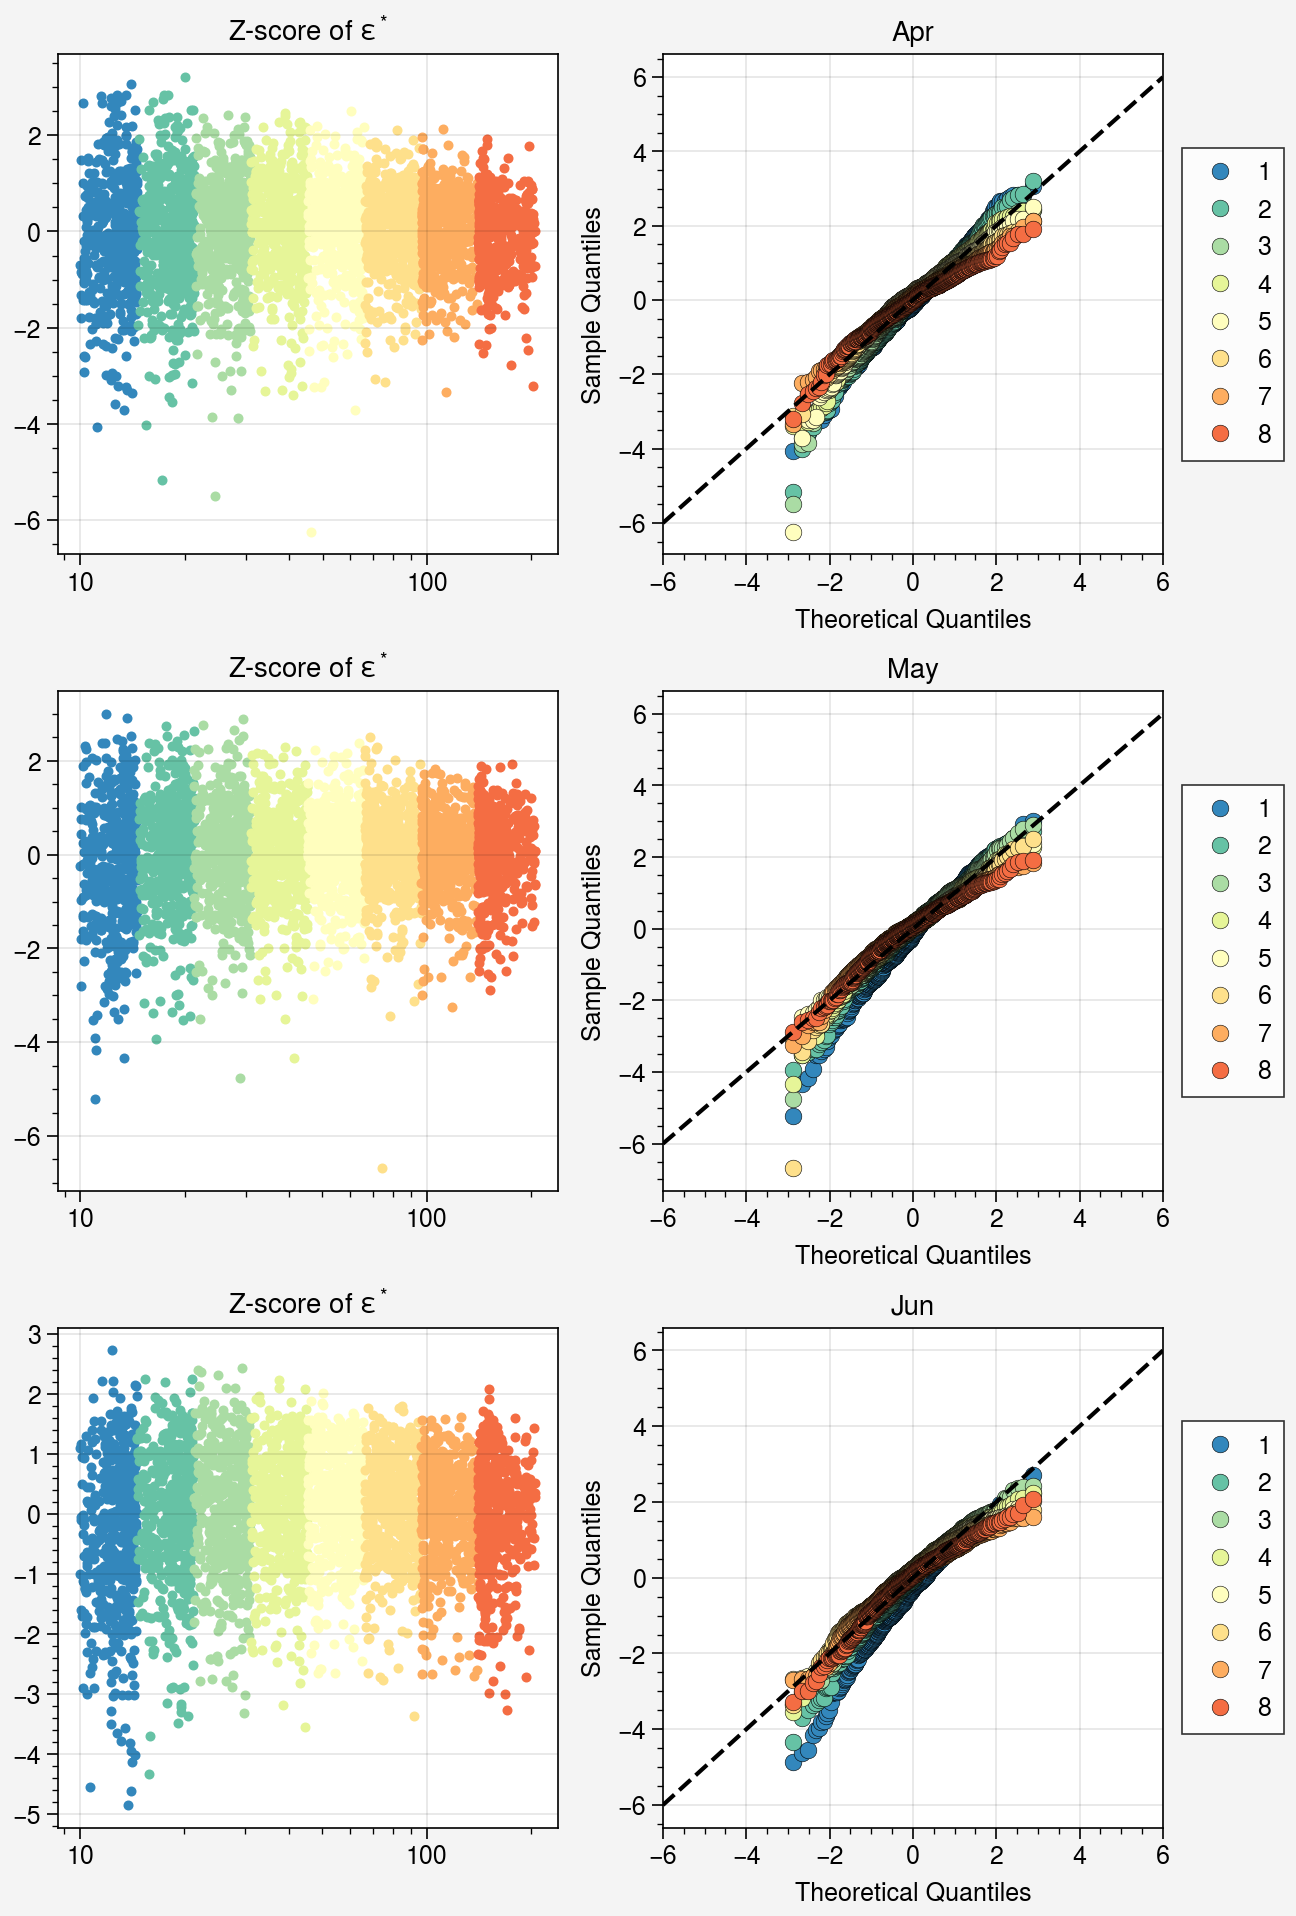

In [479]:
bincolors = {lb: color['color'] for lb, color in zip(np.arange(0, 11),
                                                pplt.Cycle('spectral_r',11))}
fig, axs = pplt.subplots(ncols=2, nrows=3, share=False)
for row, month, monthname in zip([0, 1, 2], [4, 5, 6], ['Apr', 'May', 'Jun']):
    beta_mle = bs_table.loc[month, 'beta']
    strat_samp = pd.concat(samples[month])
    data = np.log(strat_samp['total_deformation']*strat_samp['L']**beta_mle)
    data = pd.DataFrame({'Z': (data - np.mean(data))/np.std(data), 'L': strat_samp['L'], 'log_bin': strat_samp['log_bin']})
    
    axs[row, 0].format(xscale='log', title='Z-score of $\epsilon^*$')
    
    for lbin, group in data.groupby('log_bin'):
        axs[row, 0].scatter(group['L'].values, group['Z'].values, color=bincolors[lbin], marker='.')
        sm.qqplot(group['Z'], ax=axs[row, 1], **{'marker': 'o', 'markerfacecolor': bincolors[lbin], 'markeredgecolor':'k', 'markeredgewidth': 0.2, 'label': lbin})
    axs[row, 1].plot([-6, 6], [-6, 6], color='k', ls='--')
    axs[row, 1].format(title=monthname)
        # ax.hist(group['Z'], bins=np.linspace(-5, 5, 31),
        #         density=True, label='Bin {lb}: {km} km'.format(lb=lbin, km=np.round(np.mean(group['L']), 1)), histtype='step')
    axs[row, 1].legend(ncols=1, loc='r')
    

Some notes based on plotting single groups at a time:
* Small scales seem identically distributed (log bins 1 and 2). Both have a tilted qq plot showing relatively more frequent low values and less frequent high values.
* Next, 3 and 4 are closer to the lognormal distribution for the higher values, but still have relatively more frequent low Z scores
* 5-7 have more frequent high values and less frequent low values, the qq plot is skewed the opposite way
* 

0 0.82
1 0.01
2 0.51
3 0.74
4 0.03
5 0.14
6 0.03
7 0.78
8 0.95
9 0.59


<a list of 1 Line2D objects>

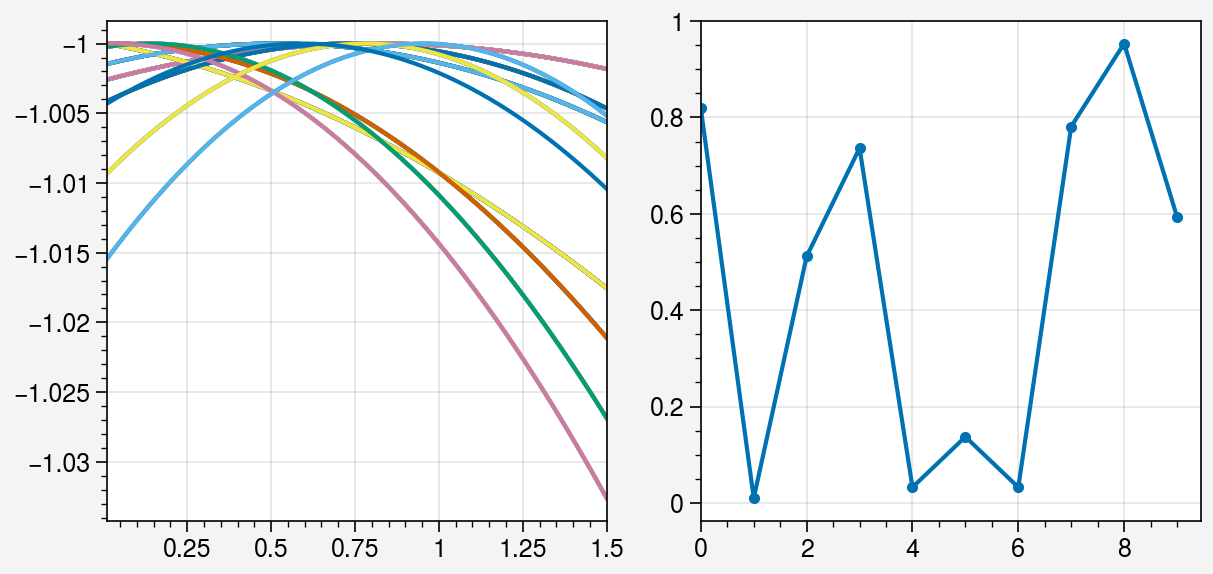

In [480]:
fig, axs = pplt.subplots(ncols=2, share=False)
likelihood_results = pd.DataFrame(np.nan, index=np.linspace(0.01, 1.5, 200), columns=np.arange(0, 11))
for binnum, data in all_results.loc[all_results.sampled,].groupby('log_bin'):
    if len(data) > 400:
        d = data['total_deformation'].sample(400)
        for beta in likelihood_results.index:
            likelihood_results.loc[beta, binnum] = normal_log_likelihood(d*(60*60*24),
                                                                 data['L'], beta)
        axs[0].plot(likelihood_results/np.abs(likelihood_results.max()))
        print(binnum, np.round(likelihood_results[binnum].idxmax(),2))
axs[1].plot(likelihood_results.idxmax(axis=0), marker='.')

# TBD
* Compare the local fit to the global fit with alternative methods of fitting a lognormal distribution. Can we rule it out? Are we getting the best mu/std estimates?

Powerlaw distribution application to the data within a length scale bin

In [592]:
import powerlaw
data = pd.concat(samples[4])
data.columns

Index(['datetime', 'triangle_number', 'floe1', 'floe2', 'floe3', 'u1', 'u2',
       'u3', 'v1', 'v2', 'v3', 'lat1', 'lat2', 'lat3', 'lon1', 'lon2', 'lon3',
       'area_km21', 'area_km22', 'area_km23', 'zeta1', 'zeta2', 'zeta3',
       'edge_dist_km1', 'edge_dist_km2', 'edge_dist_km3', 'coast_dist_km1',
       'coast_dist_km2', 'coast_dist_km3', 'polygon_area', 'min_angle', 'L',
       'log_bin', 'sampled', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'divergence',
       'vorticity', 'pure_shear', 'normal_shear', 'total_deformation', 'month',
       'year'],
      dtype='object')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


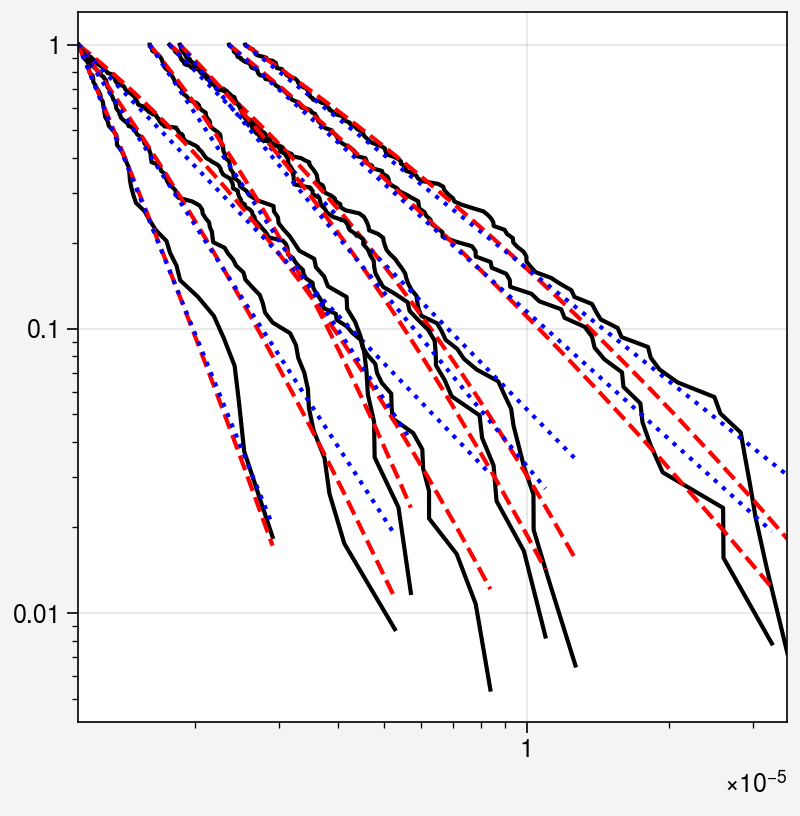

In [593]:
fig, ax = pplt.subplots(width=4)
for log_bin in range(1, 9):
    fit = powerlaw.Fit(np.abs(data.loc[data.log_bin == log_bin, 'divergence']))
    fit.plot_ccdf(ax=ax, color='k')
    fit.lognormal.plot_ccdf(ax=ax, ls='--', color='r')
    fit.power_law.plot_ccdf(ax=ax, ls=':', color='b')
# fit.exponential.plot_ccdf(ax=ax)

In [594]:
print(fit.distribution_compare('power_law', 'truncated_power_law', nested=True))
print(fit.distribution_compare('power_law', 'lognormal', nested=True))
print(fit.distribution_compare('power_law', 'exponential', nested=True))

(-0.0913193419487115, 0.6691153357561691)
(-0.04219158293382108, 0.7714430776365894)
(0.7616251254881696, 0.21712829523228583)


Assuming nested distributions


<a list of 1 Line2D objects>

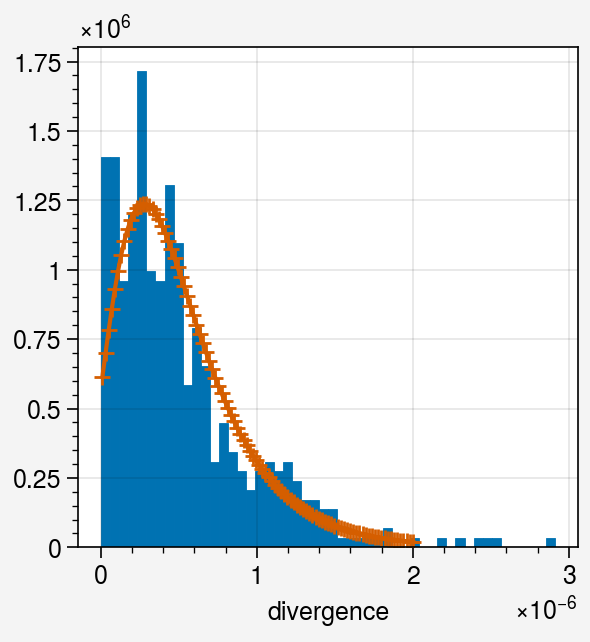

In [595]:
import scipy.stats as stats
fig, ax = pplt.subplots()
x = np.abs(data.loc[data.log_bin == log_bin, 'divergence'])
ax.hist(x, bins=50, density=True)
shape, location, scale = stats.lognorm.fit(x)
ax.plot(np.linspace(1e-8, 2e-6, 100), stats.lognorm.pdf(np.linspace(1e-8, 2e-6, 100), shape, location, scale), marker='+')
# ax.format(yscale='log', xscale='log')

In [519]:
fit.lognormal.mu, fit.lognormal.sigma

(-15.567266079668826, 0.997892889227757)

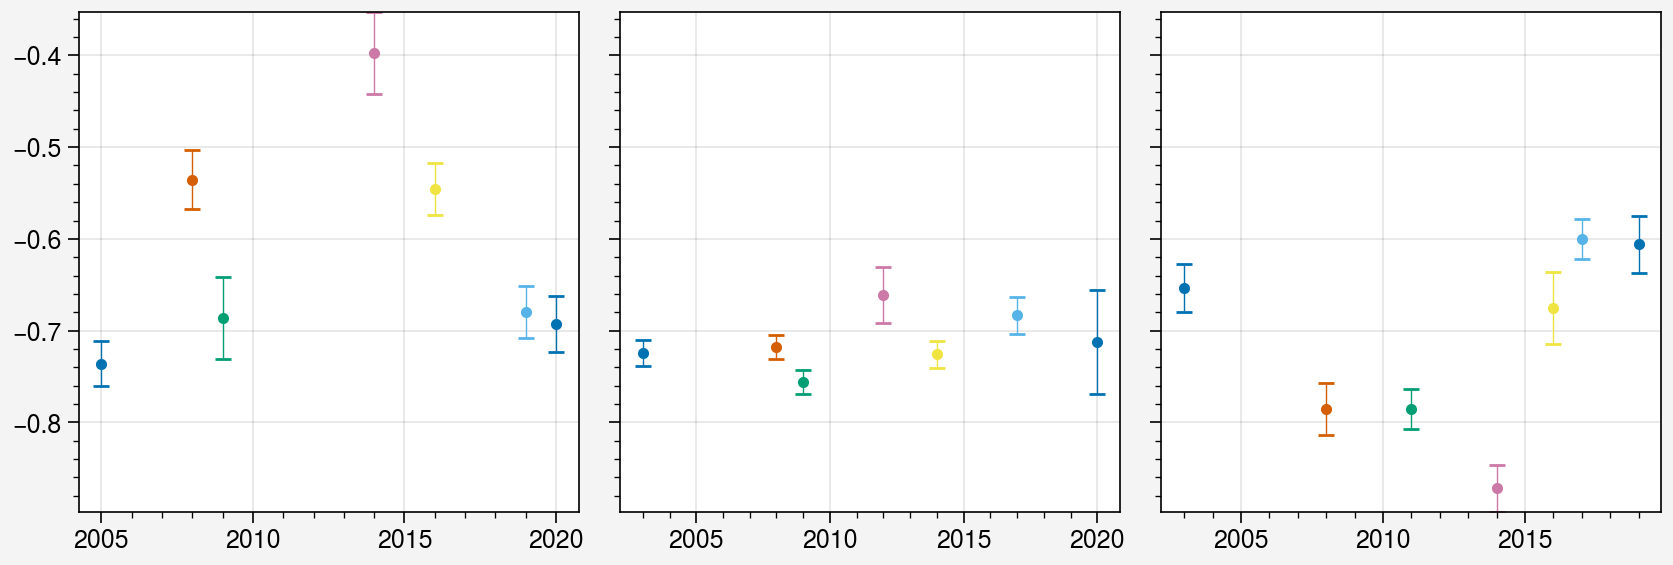

In [188]:
fig, axs = pplt.subplots(ncols=3)
for ax, month in zip(axs, range(4, 7)):
    for year in range(2003, 2021):
        data = all_results.loc[(all_results.datetime.dt.month == month) & (all_results.sampled)]
        data = data.loc[(data.datetime.dt.year == year)]
        data = data.loc[(data.log_bin > 0) & (data.log_bin < 10)]
        
        data_mean = data.loc[data.sampled,['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
        data_std = data.loc[data.sampled,['L', 'total_deformation', 'log_bin']].groupby('log_bin').std()
        n = data.loc[data.sampled,['L', 'total_deformation', 'log_bin']].groupby('log_bin').count()
        data_mean = data_mean.where(n['total_deformation'] > 50).dropna()
        data_std = data_std.where(n['total_deformation'] > 50).dropna()
        if len(data_mean) > 6:
            beta, a, r, p, err = linregress(np.log10(data_mean['L']), np.log10(data_mean['total_deformation']*24*60*60))
            
            ax.errorbar([year], [beta], lw=0.5, yerr=[err], marker='.')

In [190]:
strat_samp

,datetime,triangle_number,floe1,floe2,floe3,u1,u2,u3,v1,v2,...,y2,x3,y3,divergence,vorticity,pure_shear,normal_shear,total_deformation,month,year
2303593,2017-06-27 12:00:00,100,2017_06605,2017_06706,2017_06733,-0.06240,-0.02376,-0.03128,-0.12313,-0.06000,...,-1.243667e+06,800228.990369,-1.233436e+06,1.575616e-08,-7.786873e-06,-9.571678e-06,1.351285e-07,4.786316e-06,6,2017
547517,2004-06-06 12:00:00,145,2004_00866,2004_00917,2004_00871,-0.03536,0.01340,0.01526,0.05819,0.04256,...,-1.340278e+06,746372.657482,-1.283294e+06,7.226381e-07,-6.423151e-06,-5.815069e-06,6.353551e-06,4.306467e-06,6,2004
542489,2003-06-24 12:00:00,42,2003_06749,2003_07653,2003_07616,0.06358,0.00745,0.00706,-0.00163,0.02466,...,-1.071340e+06,628648.973907,-1.102096e+06,3.162246e-06,-1.809615e-06,-1.476308e-06,2.666603e-06,1.523996e-06,6,2003
1124256,2011-06-18 12:00:00,997,2011_01767,2011_02176,2011_01960,-0.04058,-0.10172,-0.00280,-0.12094,-0.04234,...,-1.170586e+06,811361.642999,-1.141728e+06,-2.394742e-06,-2.007667e-07,5.726732e-06,-1.710362e-06,2.988344e-06,6,2011
541978,2003-06-22 12:00:00,249,2003_07110,2003_07636,2003_07497,0.06898,0.05047,0.04365,0.09849,0.06193,...,-1.053084e+06,799213.953758,-1.091175e+06,1.270399e-06,1.275129e-06,2.422696e-06,1.255816e-07,1.212974e-06,6,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578283,2014-06-12 12:00:00,11138,2014_05841,2014_06058,2014_06123,0.00729,-0.04126,0.19339,-0.01203,-0.22351,...,-1.407251e+06,851885.810955,-1.060820e+06,1.442573e-06,-1.702346e-06,-7.513553e-07,7.152059e-07,5.186652e-07,6,2014
2637846,2019-06-14 12:00:00,8175,2019_04314,2019_04715,2019_05029,0.00437,-0.02720,-0.04884,-0.12465,-0.07141,...,-1.029972e+06,865034.034307,-7.423103e+05,9.283271e-08,1.485180e-06,1.354768e-06,-8.380519e-07,7.965122e-07,6,2019
1118480,2011-06-17 12:00:00,185,2011_01710,2011_01751,2011_02068,-0.06165,-0.06996,-0.02118,-0.03260,-0.07277,...,-1.043212e+06,719132.743611,-1.310161e+06,-4.863743e-07,-2.089590e-07,-2.928452e-07,-2.621101e-07,1.965070e-07,6,2011
1138043,2011-06-24 12:00:00,3165,2011_02529,2011_02589,2011_02612,0.13012,0.08335,-0.05788,-0.12784,0.04756,...,-1.237000e+06,800729.016800,-9.981294e+05,-2.206344e-06,3.589641e-07,3.881320e-07,-1.498049e-06,7.737567e-07,6,2011


In [16]:
df_100km.columns

Index(['datetime', 'triangle_number', 'floe1', 'floe2', 'floe3', 'u1', 'u2',
       'u3', 'v1', 'v2', 'v3', 'lat1', 'lat2', 'lat3', 'lon1', 'lon2', 'lon3',
       'area', 'min_angle', 'L', 'log_bin', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3',
       'divergence', 'vorticity', 'pure_shear', 'normal_shear',
       'total_deformation', 'month', 'year'],
      dtype='object')

In [19]:
df_ift = pd.read_csv('../data/floe_tracker/ift_with_era5.csv')

In [21]:
# Silly mistake - each floe has multiple distances.
# Need to index both by date and by floe.
# edge_dist = df_ift.loc[:, ['floe_id', 'edge_dist']].set_index('floe_id')


In [ ]:
import pandas as pd
df = pd.read_csv('../data/deformation/ift_deformation_calculations_2003.csv')

In [40]:
df = df.dropna(subset='divergence')

logbins = np.logspace(np.log(10), np.log(300), base=np.e, num=10)
df['L'] = np.sqrt(df['area_km2'])
df['log_bin'] = np.digitize(df['L'], logbins)


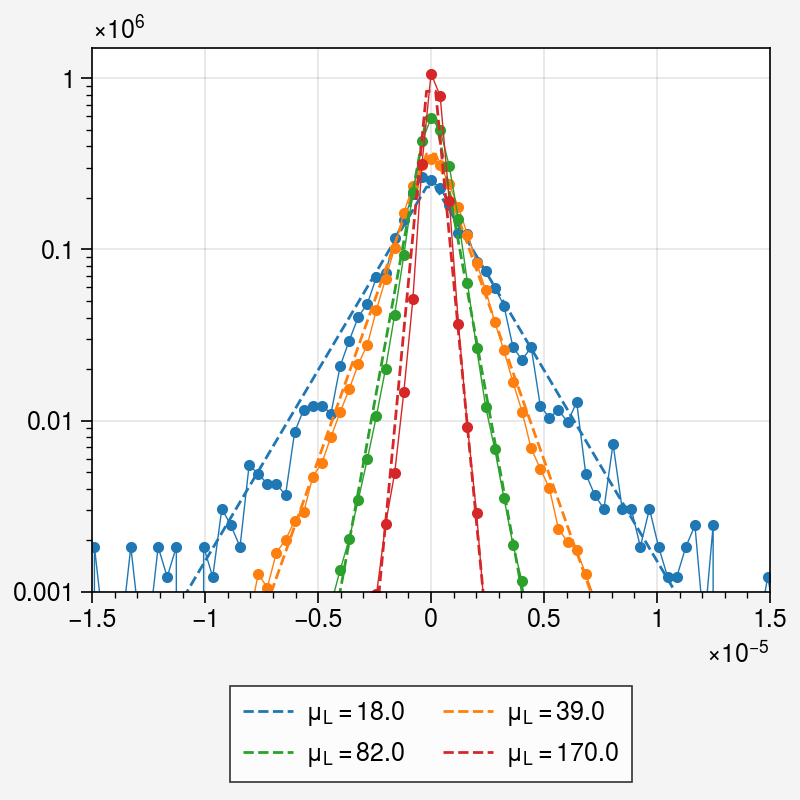

In [78]:
import scipy.stats as stats
var = 'divergence'
colors = pplt.Cycle('tab10', 8)
fig, ax = pplt.subplots(width=4, height=4)
for log_bin, c in zip(range(2, 10, 2), [x['color'] for x in colors]):
    ls = '--'
    if len(df.loc[df.log_bin==log_bin].dropna(subset=var)) > 500:
        
        train = df.loc[df.log_bin==log_bin].dropna(subset=var).sample(500, replace=False)
        # train[[var]] = train[[var]] / train[['length_bin', var]].groupby('length_bin').transform(lambda x: x.std())
        test =  df.loc[df.log_bin==log_bin].dropna(subset=var)
        test = test.loc[[x for x in test.index if x not in train.index], :]
        loc, scale = stats.expon.fit(np.abs(train[var]), floc=0)

        pdf, x_bins = np.histogram(test[var], bins=np.linspace(-3e-5, 3e-5, 150), density=True)
        x_center = 1/2*(x_bins[1:] + x_bins[:-1])
        
        ax.plot(x_center, pdf, color=c, label='', marker='.', lw=0.5)
        
        x = np.linspace(-2e-5, 2e-5, 100)
        ax.plot(x, 0.5*stats.expon(loc=loc, scale=scale).pdf(np.abs(x)), ls=ls, c=c, lw=1,
                label='$\mu_L =$' + str(np.round(test['L'].mean())))
        ax.format(yscale='log', ylim=(1e3, 1.5e6), xlim=(-1.5e-5, 1.5e-5))
ax.legend(loc='b', ncols=2)

colors = pplt.Cycle('tab10', 10)
